# Digital Economy + commoncrawl

This notebook will include tasks related to linking the digital economy project and the current commoncrawl output.

Big questions:
- Which (New Zealand) companies have a digital presence?
- Understanding traffic/sales to each company/website.
- Is a digital equivalent to the sales information collected by the CPI surveys possible?

In [1]:
import os, sys
import re
import csv
import random
import itertools
import boto3
from urllib import parse
from collections import Counter

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim

In [2]:
pandarallel.initialize(progress_bar=True)
sess = boto3.Session(profile_name="xmiles")

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
def read_csv_from_s3(bucket, key):
    s3_client = sess.client('s3')
    resp = s3_client.get_object(Bucket=bucket, Key=key)
    # Python 3.8/3.9 can't download files over 2GB via HTTP, so file is 
    # streamed just in case
    csv_str = b''.join([
        chunk for chunk in resp['Body'].iter_chunks()
    ]).decode()
    
    # keepends=True to preserve newlines within Text fields
    csv_lines = csv_str.splitlines(keepends=True)
    csv_list = list(csv.reader(csv_lines, quotechar='"'))
    df = pd.DataFrame(csv_list[1:], columns=csv_list[0])
    
    return df

## Which websites are there?

Extracting unique websites from the commoncrawl output.

In [4]:
%%time
s3 = sess.client('s3')
output_keys = [
    x['Key'] for x in
    s3.list_objects_v2(Bucket="statsnz-covid-xmiles", Prefix="commoncrawl/processed_ccmain_bunches/CC-MAIN-2021-10/")['Contents']
][:161]
all_output = pd.concat((
    read_csv_from_s3("statsnz-covid-xmiles", key) for key in output_keys
))
print(f"Number of rows: {all_output.shape[0]} (from {len(output_keys)} CSVs)")
# Number of rows: 1278870 (from 161 CSVs)

Number of rows: 1278870 (from 161 CSVs)
CPU times: user 50.3 s, sys: 6.5 s, total: 56.8 s
Wall time: 1min 38s


In [5]:
all_output.head()

,Datetime,URL,Text
0,2021-03-05T13:19:47.000Z,http://0800treetrim.nz/,Trees And First Impressions When it comes to R...
1,2021-03-05T12:38:51.000Z,http://0800treetrim.nz/author/treeguys/,Tree Care And Tree Selection\n\nTree Care star...
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...
3,2021-03-05T13:08:37.000Z,http://0800treetrim.nz/coming-soon/,Site under construction.\n\nNew tree service c...
4,2021-03-05T14:15:11.000Z,http://0800treetrim.nz/faqs/,Why 0800 Tree Trim Ltd is topping the competit...


In [6]:
def get_netloc(url):
    return parse.urlsplit(url).netloc

In [7]:
all_output['netloc'] = all_output['URL'].map(get_netloc)
all_output.head()

,Datetime,URL,Text,netloc
0,2021-03-05T13:19:47.000Z,http://0800treetrim.nz/,Trees And First Impressions When it comes to R...,0800treetrim.nz
1,2021-03-05T12:38:51.000Z,http://0800treetrim.nz/author/treeguys/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
3,2021-03-05T13:08:37.000Z,http://0800treetrim.nz/coming-soon/,Site under construction.\n\nNew tree service c...,0800treetrim.nz
4,2021-03-05T14:15:11.000Z,http://0800treetrim.nz/faqs/,Why 0800 Tree Trim Ltd is topping the competit...,0800treetrim.nz


In [8]:
unique_netlocs = set(all_output['netloc'])
print(f"There is {len(unique_netlocs)} unique netlocs from {len(all_output)} URLs")

There is 30648 unique netlocs from 1278870 URLs


Save all the unique netlocs to .txt file. 

Is a netloc/network location equivalent to a website? Yes

In [9]:
output_keys_simple = [key.split('/')[-1] for key in output_keys]
txt_str = f"CC-MAIN-2021-10 New Zealand\n" + \
          f"Included bunches: {','.join(output_keys_simple)}\n\n" + \
           "\n".join(sorted(unique_netlocs)) + "\n"

with open("ccmain-2021-10-nz-netlocs.txt", 'w') as f:
    f.write(txt_str)

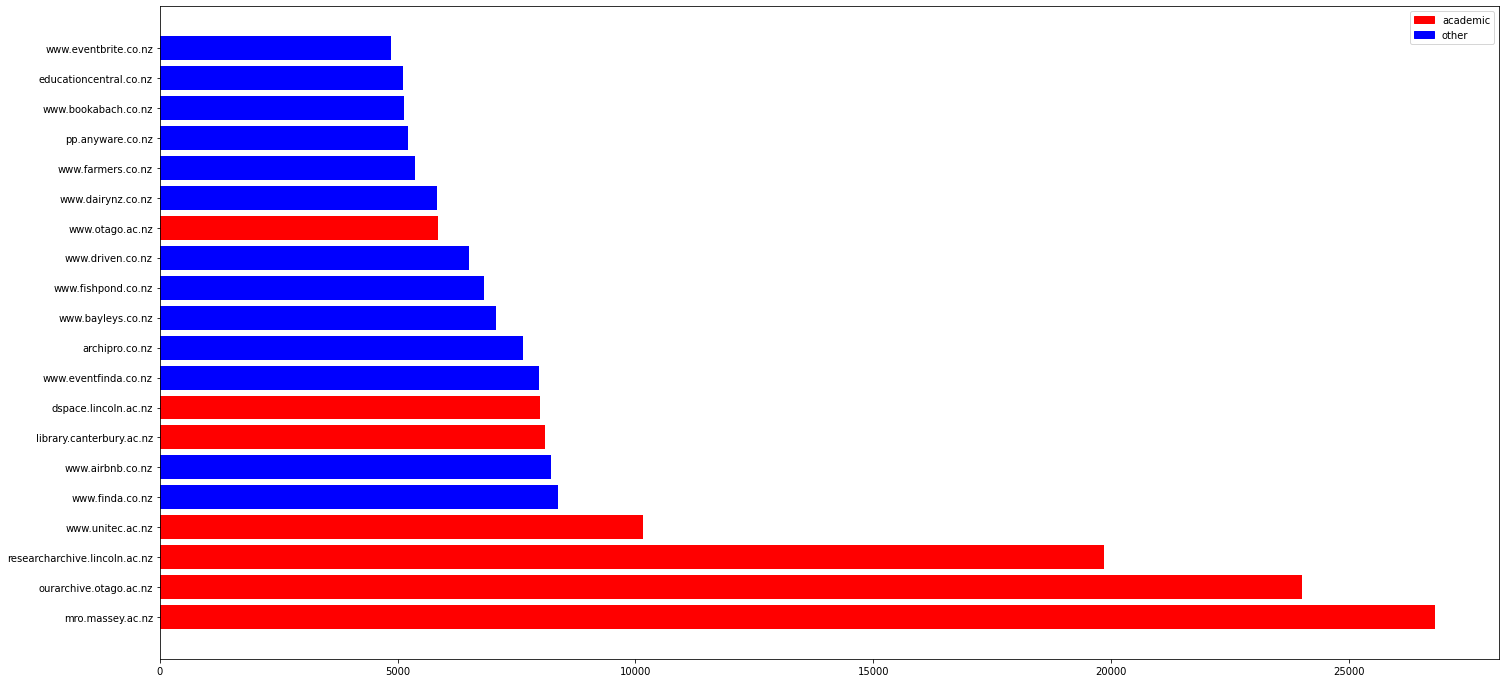

In [10]:
netloc_counter = Counter(all_output['netloc'])
top_netloc = netloc_counter.most_common(20)

top_netloc_names = [x[0] for x in top_netloc]
y_pos = range(len(top_netloc_names))
top_netloc_nums = [x[1] for x in top_netloc]
cols = ["red" if name.endswith(".ac.nz") else "blue" 
        for name in top_netloc_names]

colors = {'academic':'red', 'other':'blue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

fig, ax = plt.subplots(figsize=(24, 12))
ax.barh(y_pos, top_netloc_nums, color=cols)
ax.legend(handles, labels)
ax.set(yticks=y_pos, yticklabels=top_netloc_names);

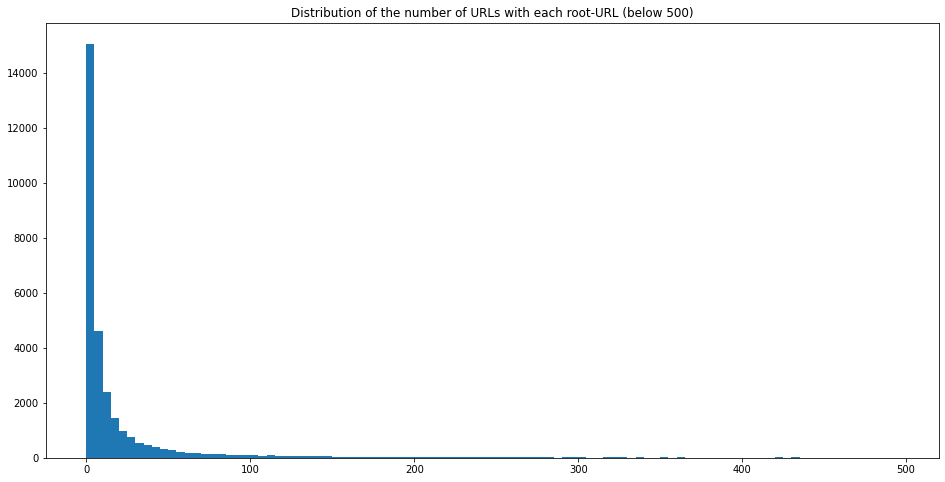

In [11]:
netloc_sorted = netloc_counter.most_common(len(netloc_counter))

netloc_nums = [x[1] for x in netloc_sorted
               if x[1] < 500]
bins = range(0, 500, 5)

fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(netloc_nums, bins=bins)
ax.set(title="Distribution of the number of URLs with each root-URL (below 500)");

## Is there any duplicate websites within the same batch?

In [12]:
all_output[all_output['URL'].duplicated(keep=False)]

,Datetime,URL,Text,netloc
75,2021-02-25T04:11:45.000Z,http://150yearspolesdownsouth.nz/,Toward the end of the 18th century the Polish-...,150yearspolesdownsouth.nz
76,2021-03-02T11:14:01.000Z,http://150yearspolesdownsouth.nz/,Toward the end of the 18th century the Polish-...,150yearspolesdownsouth.nz
214,2021-02-25T15:53:34.000Z,https://git.1j.nz/jason,declutter 0 0\n\nRemoves the clutter from vari...,git.1j.nz
215,2021-03-08T02:45:29.000Z,https://git.1j.nz/jason,declutter 0 0\n\nRemoves the clutter from vari...,git.1j.nz
220,2021-02-25T17:04:44.000Z,https://git.1j.nz/jason/declutter/src/master/p...,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,git.1j.nz
...,...,...,...,...
6670,2021-02-27T18:26:51.000Z,https://gardencityflorist.co.nz/products/pink-...,Purchasing & Delivery\n\nAt Garden City Floris...,gardencityflorist.co.nz
6671,2021-03-08T06:53:24.000Z,https://gardencityflorist.co.nz/products/pink-...,Purchasing & Delivery\n\nAt Garden City Floris...,gardencityflorist.co.nz
8255,2021-03-04T21:00:47.000Z,https://www.gardenpost.co.nz/cart/,Current Order Status\n\nGardenPost Orders: Dis...,www.gardenpost.co.nz
8256,2021-03-05T18:36:06.000Z,https://www.gardenpost.co.nz/cart/,Current Order Status\n\nGardenPost Orders: Dis...,www.gardenpost.co.nz


In [13]:
all_duplicate_url_rows = sum(all_output['URL'].duplicated(keep=False))
num_duplicate_url_rows = sum(all_output['URL'].duplicated())

print(f"{all_duplicate_url_rows} of the rows have a duplicate URL")
print(f"With duplicate URLs removed, there would be {num_duplicate_url_rows} fewer rows")
print(f"(Total number of rows: {all_output.shape[0]})")

26794 of the rows have a duplicate URL
With duplicate URLs removed, there would be 19579 fewer rows
(Total number of rows: 1278870)


In [14]:
all_output[all_output['Text'].duplicated(keep=False)]

,Datetime,URL,Text,netloc
1,2021-03-05T12:38:51.000Z,http://0800treetrim.nz/author/treeguys/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
7,2021-03-05T12:34:30.000Z,http://0800treetrim.nz/tag/add-value-to-a-prop...,Trees And First Impressions\n\nWhen it comes t...,0800treetrim.nz
8,2021-03-05T12:56:29.000Z,http://0800treetrim.nz/tag/cheap-tree-removal/,Why use professional tree specialists to remov...,0800treetrim.nz
9,2021-03-05T13:48:20.000Z,http://0800treetrim.nz/tag/choosing-the-right-...,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
...,...,...,...,...
8648,2021-03-04T21:53:25.000Z,https://gardenviewcottages.co.nz/our-facilities/,We have both grown up in the Marlborough Regio...,gardenviewcottages.co.nz
8654,2021-02-26T10:02:28.000Z,https://www.gardenwithfertnz.co.nz/my-account/...,Lost your password? Please enter your username...,www.gardenwithfertnz.co.nz
8655,2021-02-26T09:22:46.000Z,https://www.gardenwithfertnz.co.nz/product-cat...,SHIPPING\n\nNelson/Tasman Shipping\n\nFree pic...,www.gardenwithfertnz.co.nz
8658,2021-02-26T08:58:40.000Z,https://www.gardenwithfertnz.co.nz/shop/?v=872...,SHIPPING\n\nNelson/Tasman Shipping\n\nFree pic...,www.gardenwithfertnz.co.nz


In [15]:
all_duplicate_text_rows = sum(all_output['Text'].duplicated(keep=False))
num_duplicate_text_rows = sum(all_output['Text'].duplicated())

print(f"{all_duplicate_text_rows} of the rows have a duplicate URL")
print(f"With duplicate URLs removed, there would be {num_duplicate_text_rows} fewer rows")
print(f"(Total number of rows: {all_output.shape[0]})")

651951 of the rows have a duplicate URL
With duplicate URLs removed, there would be 584838 fewer rows
(Total number of rows: 1278870)


In [16]:
all_output[all_output['Text'].duplicated(keep='first')]

,Datetime,URL,Text,netloc
2,2021-03-05T12:52:16.000Z,http://0800treetrim.nz/category/treework/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
9,2021-03-05T13:48:20.000Z,http://0800treetrim.nz/tag/choosing-the-right-...,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
10,2021-03-05T13:58:26.000Z,http://0800treetrim.nz/tag/company-to-remove-t...,Why use professional tree specialists to remov...,0800treetrim.nz
12,2021-03-05T14:11:25.000Z,http://0800treetrim.nz/tag/how-to-care-for-trees/,Tree Care And Tree Selection\n\nTree Care star...,0800treetrim.nz
13,2021-03-05T13:36:32.000Z,http://0800treetrim.nz/tag/how-to-remove-a-lar...,Why use professional tree specialists to remov...,0800treetrim.nz
...,...,...,...,...
8646,2021-03-04T22:34:37.000Z,https://gardenviewcottages.co.nz/karaka-cottage/,We have both grown up in the Marlborough Regio...,gardenviewcottages.co.nz
8648,2021-03-04T21:53:25.000Z,https://gardenviewcottages.co.nz/our-facilities/,We have both grown up in the Marlborough Regio...,gardenviewcottages.co.nz
8654,2021-02-26T10:02:28.000Z,https://www.gardenwithfertnz.co.nz/my-account/...,Lost your password? Please enter your username...,www.gardenwithfertnz.co.nz
8658,2021-02-26T08:58:40.000Z,https://www.gardenwithfertnz.co.nz/shop/?v=872...,SHIPPING\n\nNelson/Tasman Shipping\n\nFree pic...,www.gardenwithfertnz.co.nz


## Predicting which websites are ecommerce

### Semi-unsupervised: naive searching the URL and text.

In [17]:
url_shop_mask = all_output['URL'].str.contains("shop")
netloc_dup_and_url_shop_mask = all_output[url_shop_mask]['netloc'].duplicated()
all_output[url_shop_mask][~netloc_dup_and_url_shop_mask]

,Datetime,URL,Text,netloc
170,2021-02-27T11:56:07.000Z,https://1878kitchen.nz/index.php/shop/,× Booking Quote\n\nBe Aware that no money chan...,1878kitchen.nz
199,2021-02-25T08:14:42.000Z,https://www.1hour.nz/shop/,Home / Shop\n\nShop,www.1hour.nz
666,2021-03-06T14:52:06.000Z,https://1outlets.nz/jim-shore-heartwood-creek-...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
1158,2021-02-25T07:39:06.000Z,https://www.24-7youthwork.nz/shop/cart/,Your cart is currently empty.\n\nYour cart is ...,www.24-7youthwork.nz
1264,2021-03-01T15:39:10.000Z,https://www.2degrees.nz/help/shop-and-orders,Boost your Wifi with our Wifi Extender\n\nSign...,www.2degrees.nz
...,...,...,...,...
6590,2021-03-04T05:43:44.000Z,https://www.gardenchess.co.nz/shop/,Get The Most With Both! Giant Chess and Mini G...,www.gardenchess.co.nz
6737,2021-02-28T19:00:09.000Z,https://www.gardenfestnz.co.nz/events/garden-f...,with The Jewel and the Jeweller\n\nFounded by ...,www.gardenfestnz.co.nz
8189,2021-03-01T19:01:06.000Z,https://gardenorganics.co.nz/shop/,Over the last 10 years we have supplied the lo...,gardenorganics.co.nz
8595,2021-03-08T17:54:20.000Z,https://gardenshedco.co.nz/product-category/ra...,This site uses cookies. By continuing to brows...,gardenshedco.co.nz


In [18]:
url_store_mask = all_output['URL'].str.contains("store")
netloc_dup_and_url_store_mask = all_output[url_store_mask]['netloc'].duplicated()
all_output[url_store_mask][~netloc_dup_and_url_store_mask]

,Datetime,URL,Text,netloc
279,2021-03-02T04:11:17.000Z,https://1outlets.nz/?___store=storeview_1outle...,1Outlets.com\n\n1Outlets.com - a trademark of ...,1outlets.nz
1786,2021-02-27T12:07:18.000Z,https://3dprinter.nz/3d-printing-rotorua-store/,Our little online 3D Printing Rotorua store li...,3dprinter.nz
87,2021-03-01T09:07:12.000Z,https://campusstore.auckland.ac.nz/metal-drink...,We promise to never spam you and just use your...,campusstore.auckland.ac.nz
267,2021-02-27T08:59:07.000Z,https://store.creative.auckland.ac.nz/,Please Note: For payments by credit or debit c...,store.creative.auckland.ac.nz
334,2021-03-03T09:21:12.000Z,https://store.educationcentre.auckland.ac.nz/a...,Product Description Authors Gill Connell and C...,store.educationcentre.auckland.ac.nz
...,...,...,...,...
4408,2021-03-09T10:49:54.000Z,https://store.gameon.co.nz/app,Sign Up to become a member and access exclusiv...,store.gameon.co.nz
4875,2021-02-26T18:43:50.000Z,https://www.gameplanet.co.nz/pc/news/g54af42bc...,Updated 9/1 5:37pm:\n\nAn EB Games spokesperso...,www.gameplanet.co.nz
5904,2021-03-04T13:19:04.000Z,https://www.gammasolutions.co.nz/white-papers/...,Store-level execution is under the spotlight a...,www.gammasolutions.co.nz
5917,2021-02-26T16:06:43.000Z,https://gammaweb.co.nz/mobile-marketing-and-ap...,We are a team of innovators developers and pro...,gammaweb.co.nz


Searching the URL seems to pick up a lot of false positives e.g. "workshop" is picked up when searching for "shop"; searching for "store" picks up a webpage about an physical store (not an online store). "Product" seems to pick up the most ecommerce, but still returns plenty of non-ecommerce sites.

In [19]:
all_output[all_output['URL'].str.contains('plant')]

,Datetime,URL,Text,netloc
353,2021-02-28T09:31:54.000Z,https://1outlets.nz/beewarm-pump-sprayer-garde...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
519,2021-02-25T14:00:04.000Z,https://1outlets.nz/foods-alive-nutritional-ye...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
709,2021-02-27T19:00:55.000Z,https://1outlets.nz/listo-10-inch-sierra-plant...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
710,2021-02-24T19:59:32.000Z,https://1outlets.nz/listo-10-inch-sierra-plant...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
711,2021-03-02T07:27:22.000Z,https://1outlets.nz/listo-10-inch-sierra-plant...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
...,...,...,...,...
8176,2021-03-01T19:46:05.000Z,https://gardenorganics.co.nz/product-category/...,Summertime flavours are on their way! These basil,gardenorganics.co.nz
8240,2021-02-26T21:51:51.000Z,https://www.gardenornaments.co.nz/view/moulds-...,Many parts of this website requires javascript...,www.gardenornaments.co.nz
8543,2021-03-08T06:04:22.000Z,https://gardenservicesauckland.co.nz/moth-plan...,We remove your moth plant for you! Leave it to...,gardenservicesauckland.co.nz
8564,2021-03-08T06:59:25.000Z,https://gardenservicesauckland.co.nz/tag/moth-...,We remove your moth plant for you! Leave it to...,gardenservicesauckland.co.nz


In [260]:
product_mask = all_output['URL'].str.contains('product')
first_product_mask = ~all_output[product_mask]['netloc'].duplicated()
all_output[product_mask][first_product_mask]

,Datetime,URL,Text,netloc
133,2021-02-27T12:39:17.000Z,https://1878kitchen.nz/index.php/product-categ...,× Booking Quote\n\nBe Aware that no money chan...,1878kitchen.nz
189,2021-03-04T21:04:43.000Z,https://www.1hour.nz/product-category/accessor...,Home / Shop Accessories\n\nShop Accessories\n\...,www.1hour.nz
296,2021-02-28T18:32:34.000Z,https://1outlets.nz/aja-video-rear-baseplate-w...,Details\n\nMore Information\n\nTerms & Warning...,1outlets.nz
1780,2021-02-26T19:18:15.000Z,https://www.3dlightfx.nz/action-lights?categor...,Looks like Donatello's right hand has come thr...,www.3dlightfx.nz
1787,2021-02-26T19:35:54.000Z,https://3dprinter.nz/3d-printing-rotorua-store...,Our little online 3D Printing Rotorua store li...,3dprinter.nz
...,...,...,...,...
8524,2021-03-08T12:46:35.000Z,https://www.gardensalive.co.nz/product/1735060,BIO - FILTER FEATURES\n\nMulti-stage biologica...,www.gardensalive.co.nz
8528,2021-03-05T11:22:06.000Z,https://gardenscape.co.nz/products/,Fertiliser\n\nWe recommend using fertilizer wi...,gardenscape.co.nz
8590,2021-03-08T18:05:59.000Z,https://gardenshedco.co.nz/product-category/ga...,NZ Made Galvo Premium Garden Sheds\n\nGalvo Pr...,gardenshedco.co.nz
8655,2021-02-26T09:22:46.000Z,https://www.gardenwithfertnz.co.nz/product-cat...,SHIPPING\n\nNelson/Tasman Shipping\n\nFree pic...,www.gardenwithfertnz.co.nz


In [ ]:
%%time
con_shop_mask = condensed['Cleantext'].str.contains('shop')
con_store_mask = condensed['Cleantext'].str.contains('store')
con_quote_mask = condensed['Cleantext'].str.contains('quote')
con_mask = np.logical_or.reduce((con_shop_mask, con_store_mask, con_quote_mask))

In [ ]:
%%time
con_mask2 = np.array([True if re.search("shop|store|quote", text) else False 
                      for text in condensed['Cleantext']])

In [ ]:
np.all(con_mask == con_mask2)

### Supervised learning #1: tfidf with sklearn

In [452]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [364]:
ecom = {
    'artprints.co.nz': True,
    'cafefresca.co.nz': False, # can send request for booking
    'cafeberlin.co.nz': False,
    'stuart.blogtown.co.nz': False,
    'www.complying.co.nz': False,
    'autosmart.co.nz': True,
    'www.fairyflowers.co.nz': True,
    'bernadettepeters.co.nz': False, # broken URL
    'clarityfunds.co.nz': True, # apply for managed fund
    'ecotectural.co.nz': False,
    'www.alsdeli.nz': False,
    'www.fundmaster.co.nz': False,
    'cafecoco.co.nz': True,
    'www.frenchdoor.co.nz': False, # quote
    'dentaltec.co.nz': False, # broken URL
    'www.crownbrush.co.nz': True,
    'www.climbsafepro.co.nz': False, # quote
    'www.boomgolf.co.nz': False,
    'countrycaterers.co.nz': False,
    'www.bal.co.nz': False,
    'www.flightcentre.co.nz': False, # quote
    'activeinteriors.co.nz': False, # broken URL
    'www.gabitesltd.co.nz': False,
    'acerental.co.nz': True, # can agree to T&C to start trading
    'discoveries.co.nz': True,
    'www.cmglass.nz': False, # quote
    'www.fodda.co.nz': True,
    'bencurious.co.nz': False,
    'aboutus.co.nz': False,
    'www.finelinemarine.co.nz': False,
    'easternlivestock.co.nz': False,
    'gardenbnb.co.nz': False, # contact for prices
    'frenchkiss.co.nz': True,
    '41south.nz': False,
    'www.farmshopauction.co.nz': True,
    'www.dancehub.co.nz': False,
    'www.computerrepair.co.nz': False,
    'www.bestcaravans.co.nz': False,
    'bagnallhill.co.nz': False,
    'contactsplus.co.nz': False,
    'autogasspecialists.co.nz': False,
    'academic-consulting.co.nz': False,
    'www.curerowing.co.nz': False,
    'dementiacarenz.co.nz': False,
    'flackswong.co.nz': False,
    'aprconsultants.co.nz': False,
    'www.baytag.co.nz': False,
    'www.chainon.co.nz': False,
    'addtocontainer.co.nz': True,
    'www.evinrude.co.nz': False, # lists specific prices
    'eventservices.co.nz': False,
    'expressionz.co.nz': False,
    'old.broadbandcompare.co.nz': True, # redirects to other ecom websites
    'www.controlyourfuture.co.nz': False, # pyramid scheme
    'www.estuaryarts.co.nz': False,
    'www.accentshostel.nz': True, # redirects to booking system
    'www.bigsisters.co.nz': False,
    'www.cranfield.co.nz': False,
    'aimeenicole.co.nz': True, # ? DOUBLE CHECK ?
    'www.computergate.co.nz': False,
    'www.christinecookjewellery.co.nz': False,
    'clarkemckenzie.nz': True,
    'www.cliffedge.co.nz': True,
    'online.clickview.co.nz': False,
    'deepanimation.co.nz': True,
    'www.avodah.co.nz': False,
    'www.fitzpatricks.co.nz': False,
    'embassy3.co.nz': True,
    'directus.co.nz': False,
    'www.centralofficesupplies.co.nz': False,
    'a1kitchens.co.nz': False,
    'cloakecreative.co.nz': False,
    'www.cambridgebaptist.co.nz': False,
    'allfence.co.nz': True,
    'aih.aut.ac.nz': False,
    'www.buzzbrandpromotions.co.nz': False, # almost
    'aucklandminigarage.co.nz': True, # ? DOUBLE CHECK ?
    'ardo.co.nz': True,
    'deciphergroup.co.nz': False,
    'collaboration.co.nz': False, # domain for sale
    'bohosoul.co.nz': True,
    'www.4androtary.co.nz': True, # link to sales (partner) site
    'www.bmorewealthy.co.nz': False,
    'altasurf.co.nz': True,
    'eventspace.co.nz': False,
    'www.casinoblox.co.nz': True, # link to purchases
    'ebg.co.nz': False,
    'brickstackers.nz': False, # broken URL
    'ckswagworks.co.nz': True,
    'www.botanicabeauty.co.nz': False,
    'fmglaw.co.nz': False,
    'codingacademy.co.nz': True,
    'galleonrecruitment.co.nz': False,
    'beatsclothing.co.nz': True,
    'www.bayfordnapier.co.nz': False,
    'www.amyt.co.nz': False,
    'a1shuttle.co.nz': False, # enquiry form has specifics
    'www.allurehairstudio.co.nz': True,
    'adamas.co.nz': True,
    'www.cnissa.co.nz': False,
    'www.cellarselection.co.nz': True,
    'shop.celebrationsgroup.co.nz': True,
    'www.eclipsepharmacy.co.nz': True,
    'fujimae.co.nz': True,
    'www.brm.co.nz': True,
    'ecofriend.co.nz': True,
    'emoto.co.nz': True,
    'www.everoutdoor.co.nz': True,
    'www.broadbandcompare.co.nz': True,
    'www.ctomi.co.nz': True,
    'www.etrapper.co.nz': True,
    'www.candlecreations.co.nz': True,
    'www.bloomlearningtechnologies.co.nz': False, # ??
    'ecospas.co.nz': True,
    'ashdesign.co.nz': False,
    'www.donnafarhi.co.nz': True,
    'catevolution.co.nz': True,
    'dbrief.co.nz': True,
    'www.amazethecardshop.co.nz': True,
    'jobs.cari.co.nz': False, # very close
    'www.atwistedbunch.co.nz': True,
    'www.digitalpopup.co.nz': True,
    'www.flyingdoctor.co.nz': True,
    'www.darkheart.co.nz': True,
    'decal.co.nz': True,
    'www.blueduckpackrafting.co.nz': True,
    'www.creativedisplays.co.nz': False, # quotes
    'www.cloudink.co.nz': True,
    'canon.boostwebstore.co.nz': True,
    'www.egwebdesign.co.nz': False,
    'www.bencorp.co.nz': True,
    'cohe.co.nz': True,
    'www.aladdins.co.nz': True,
    'www.bluecat.co.nz': True, # quote
    'www.demeritcheck.co.nz': True,
    'www.aquatrip.co.nz': True,
    'www.baked.co.nz': True,
    'dwights.co.nz': True,
    'www.fujifilm.co.nz': True, # ? DOUBLE CHECK ?
    'www.clickpics.co.nz': False,
    'www.corohawk.co.nz': True,
    'archipro.co.nz': False, # very close
    'burgerburger.co.nz': True,
    '8.co.nz': False,
    'www.chillihub.co.nz': True,
    'www.freeparking.co.nz': True,
    'clicksafe.co.nz': True,
    'dillengerelectricbikes.co.nz': True,
    'chasingmercury.co.nz': True,
    'alibarbers.co.nz': True,
    'douglasroofing.co.nz': False,
    'www.embrayce.co.nz': True,
    'bayonet.co.nz': False,
    'fortgreene.co.nz': True,
    'bouteljeproducts.co.nz': False,
    'crackerjacktoys.co.nz': True,
    'solematenz.alteredegodesign.co.nz': True,
    'epicinnovation.co.nz': True,
    'nz.flexigroup.co.nz': False,
    'www.attends.co.nz': False,
    'www.cargobrewery.co.nz': True,
    'www.citrox.co.nz': False,
    'www.durasteel.co.nz': False,
    'www.aucklandclotheslines.co.nz': True,
    'www.cashburst.co.nz': True,
    'chanz.nz': False,
    'www.coolkiwikids.co.nz': True,
    'constantino.co.nz': False,
    'www.conceptskincare.co.nz': True,
    'www.acryfab.co.nz': False,
    'apostlehotsauce.co.nz': True,
    'www.emblems.co.nz': True,
    'albienursingattire.co.nz': True,
    'boomboy.co.nz': True
}
print(f"ecom True:   {sum(ecom.values()) / len(ecom):.4f}%\n"
      f"ecom - True: {sum(ecom.values())}, False: {len(ecom) - sum(ecom.values())}")
# print(f"ecom Length: {len(ecom)}")

product_mask = all_output['URL'].str.contains('product')
first_product_mask = ~all_output[product_mask]['netloc'].duplicated()
product = all_output[product_mask][first_product_mask]['netloc'].tolist()
random.seed(777)
random.shuffle(product)

for netloc in product:
    if (sum(ecom.values()) == len(ecom) / 2):
        print("balanced")
        break
    
    if netloc not in ecom.keys():
        urls = all_output[all_output['netloc'] == netloc]['URL']
        print(f"{netloc} ({len(urls)})\n")
        for url in urls:
            if "product" in url: print("YYY ", end="")
            print(url)
        break

ecom True:   0.5000%
ecom - True: 87, False: 87
balanced


In [365]:
ecom_df = pd.DataFrame([(k, int(v)) for k, v in ecom.items()], 
                       columns=['netloc', 'target'])

In [366]:
sample_output = all_output[all_output['netloc'].isin(ecom_df['netloc'])].reset_index()
sample_output.shape

(19761, 5)

In [367]:
def text_to_sentences(text):
    good = nltk.tokenize.sent_tokenize(text)
    # nltk method doesn't handle newlines, so need extra step to remove these
    better = list(filter(None, '\n'.join(good).split('\n')))
    return better

In [368]:
%%time
# all_output['sentences'] = all_output['Text'].parallel_map(text_to_sentences)
sample_output['sentences'] = sample_output['Text'].map(text_to_sentences)

CPU times: user 5.18 s, sys: 0 ns, total: 5.18 s
Wall time: 5.18 s


In [373]:
%%time
# all_output['Cleantext'] = all_output['sentences'].str.join(' ')
sample_output['Cleantext'] = sample_output['sentences'].str.join(' ')

CPU times: user 56.1 ms, sys: 2.6 ms, total: 58.7 ms
Wall time: 55.1 ms


In [374]:
# all_output.head()
sample_output.head()

,index,Datetime,URL,Text,netloc,sentences,Cleantext
0,1856,2021-03-09T06:24:28.000Z,http://41south.nz/,To the right is the 3 day NZ MetService foreca...,41south.nz,[To the right is the 3 day NZ MetService forec...,To the right is the 3 day NZ MetService foreca...
1,1857,2021-03-09T06:32:36.000Z,http://41south.nz/about/,15.7 °C About This Weather Station Observation...,41south.nz,[15.7 °C About This Weather Station Observatio...,15.7 °C About This Weather Station Observation...
2,1858,2021-03-09T06:56:37.000Z,http://41south.nz/graphs/,Observations are powered by Weewx and WeatherD...,41south.nz,[Observations are powered by Weewx and Weather...,Observations are powered by Weewx and WeatherD...
3,1859,2021-03-09T07:31:05.000Z,http://41south.nz/graphs/?graph=AQM,Observations are powered by Weewx and WeatherD...,41south.nz,[Observations are powered by Weewx and Weather...,Observations are powered by Weewx and WeatherD...
4,1860,2021-03-09T07:27:53.000Z,http://41south.nz/graphs/?graph=Day,Observations are powered by Weewx and WeatherD...,41south.nz,[Observations are powered by Weewx and Weather...,Observations are powered by Weewx and WeatherD...


Combine the dataframe into one row per netloc/root-URL, with the Text being combined into one big string.

In [376]:
# condensed = all_output
condensed = pd.DataFrame(
    sample_output.groupby('netloc')['Cleantext'].apply(' | '.join)
).reset_index(level=0)
condensed['target'] = [int(ecom[netloc]) for netloc in condensed['netloc']]
condensed.tail()

,netloc,Cleantext,target
169,www.freeparking.co.nz,Creating and launching your very own website h...,1
170,www.frenchdoor.co.nz,How to Care for your Joinery | How to Care for...,0
171,www.fujifilm.co.nz,instax - our Instant Photo System Capture all ...,1
172,www.fundmaster.co.nz,Commercial Offering New Zealanders are by and ...,0
173,www.gabitesltd.co.nz,Business Advisory Services Our knowledge and s...,0


In [422]:
ecom_train, ecom_test = train_test_split(condensed, test_size=0.2, stratify=condensed['target'])
print(f"Train: {ecom_train.shape[0]}, Test: {ecom_test.shape[0]}")

print("\nBREAKDOWN:")
print(f"Train - ecom: {sum(ecom_train['target'])}, not-ecom: {len(ecom_train) - sum(ecom_train['target'])}")
print(f"Test - ecom: {sum(ecom_test['target'])}, not-ecom: {len(ecom_test) - sum(ecom_test['target'])}")

Train: 139, Test: 35

BREAKDOWN:
Train - ecom: 70, not-ecom: 69
Test - ecom: 17, not-ecom: 18


In [423]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
ecom_train_tfidf = tfidf_vectorizer.fit_transform(ecom_train['Cleantext'])
ecom_test_tfidf = tfidf_vectorizer.transform(ecom_test['Cleantext'])
clf = MultinomialNB().fit(ecom_train_tfidf, ecom_train['target'])
ecom_test_pred = clf.predict(ecom_test_tfidf)

In [424]:
np.mean(ecom_test_pred == ecom_test['target'])

0.5142857142857142

In [425]:
ecom_train_tfidf.shape

(139, 57216)

In [438]:
df = pd.DataFrame(ecom_train_tfidf[0].T.todense(), index=tfidf_vectorizer.get_feature_names(),
                  columns=["tfidf"])
df.sort_values(by=["tfidf"], ascending=False)

,tfidf
litter,0.504330
the,0.367718
robot,0.295643
to,0.260616
cat,0.226204
...,...
eos,0.000000
ep,0.000000
epa,0.000000
epas,0.000000


In [451]:
i = 6000
print("Name:", tfidf_vectorizer.get_feature_names()[i])
print("Vector:", ecom_train_tfidf[:, i].T.todense().tolist())

Name: anxiety
Vector: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004500339344394579, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007847202547743938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03771472053692339, 0.0, 0.0, 0.0, 0.0, 0.0, 8.036525686940691e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.3291239699438876e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00427480537655327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


Build an sklearn pipeline to make this train/test process easier.

In [465]:
def print_summary(actual, pred):
    print(f"Accuracy  (dumb)  | {metrics.accuracy_score(actual, pred):.4f}\n"
          f"Precision         | {metrics.precision_score(actual,pred):.4f}\n"
          f"Recall            | {metrics.recall_score(actual, pred):.4f}\n")
    
    print(f"Predicted classes | {set(pred)}\n"
          f"Actual classes    | {set(actual)}\n")
    
    print(f"Predicted {np.array(pred)}\n"
          f"Actual    {np.array(actual)}")

In [466]:
# Naive Bayes
nb_text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
nb_text_clf.fit(ecom_train['Cleantext'], ecom_train['target'])
nb_pred = nb_text_clf.predict(ecom_test['Cleantext'])

print_summary(ecom_test['target'], nb_pred)

Accuracy  (dumb)  | 0.5143
Precision         | 0.5000
Recall            | 1.0000

Predicted classes | {0, 1}
Actual classes    | {0, 1}

Predicted [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Actual    [0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1]


In [467]:
# Support vector machine
sgd_text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=777,
                          max_iter=5, tol=None))
])
sgd_text_clf.fit(ecom_train['Cleantext'], ecom_train['target'])
sgd_pred = sgd_text_clf.predict(ecom_test['Cleantext'])

print_summary(ecom_test['target'], sgd_pred)

Accuracy  (dumb)  | 0.6857
Precision         | 0.6154
Recall            | 0.9412

Predicted classes | {0, 1}
Actual classes    | {0, 1}

Predicted [0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
Actual    [0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1]


### Supervised Learning #2: Doc2Vec

In [486]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [499]:
%%time
condensed['words'] = [
    [word.lower() for word in nltk.word_tokenize(text) if len(word) > 1]
    for text in condensed['Cleantext']
]
condensed.head()

CPU times: user 20.5 s, sys: 137 ms, total: 20.7 s
Wall time: 20.7 s


,netloc,Cleantext,target,sentences,words,tagged_words
0,41south.nz,To the right is the 3 day NZ MetService foreca...,0,"[To, the, right, is, the, 3, day, NZ, MetServi...","[to, the, right, is, the, day, nz, metservice,...","([to, the, right, is, the, day, nz, metservice..."
1,8.co.nz,Choosing Uncomplicated Secrets Of fdating Gene...,0,"[Choosing, Uncomplicated, Secrets, Of, fdating...","[choosing, uncomplicated, secrets, of, fdating...","([choosing, uncomplicated, secrets, of, fdatin..."
2,a1kitchens.co.nz,DESIGN - MANUFACTURE - INSTALLATION A1 Kitchen...,0,"[DESIGN, -, MANUFACTURE, -, INSTALLATION, A1, ...","[design, manufacture, installation, a1, kitche...","([design, manufacture, installation, a1, kitch..."
3,a1shuttle.co.nz,Ray was born in Blenheim and since 2007 he has...,0,"[Ray, was, born, in, Blenheim, and, since, 200...","[ray, was, born, in, blenheim, and, since, 200...","([ray, was, born, in, blenheim, and, since, 20..."
4,aboutus.co.nz,New Zealand Sports Sports in New Zealand are u...,0,"[New, Zealand, Sports, Sports, in, New, Zealan...","[new, zealand, sports, sports, in, new, zealan...","([new, zealand, sports, sports, in, new, zeala..."


In [500]:
%%time
condensed['tagged_words'] = [
    TaggedDocument(words=words, tags=[target]) 
    for words, target in zip(condensed['words'], condensed['target'])
]
condensed.head()

CPU times: user 285 ms, sys: 19.7 ms, total: 304 ms
Wall time: 301 ms


,netloc,Cleantext,target,sentences,words,tagged_words
0,41south.nz,To the right is the 3 day NZ MetService foreca...,0,"[To, the, right, is, the, 3, day, NZ, MetServi...","[to, the, right, is, the, day, nz, metservice,...","([to, the, right, is, the, day, nz, metservice..."
1,8.co.nz,Choosing Uncomplicated Secrets Of fdating Gene...,0,"[Choosing, Uncomplicated, Secrets, Of, fdating...","[choosing, uncomplicated, secrets, of, fdating...","([choosing, uncomplicated, secrets, of, fdatin..."
2,a1kitchens.co.nz,DESIGN - MANUFACTURE - INSTALLATION A1 Kitchen...,0,"[DESIGN, -, MANUFACTURE, -, INSTALLATION, A1, ...","[design, manufacture, installation, a1, kitche...","([design, manufacture, installation, a1, kitch..."
3,a1shuttle.co.nz,Ray was born in Blenheim and since 2007 he has...,0,"[Ray, was, born, in, Blenheim, and, since, 200...","[ray, was, born, in, blenheim, and, since, 200...","([ray, was, born, in, blenheim, and, since, 20..."
4,aboutus.co.nz,New Zealand Sports Sports in New Zealand are u...,0,"[New, Zealand, Sports, Sports, in, New, Zealan...","[new, zealand, sports, sports, in, new, zealan...","([new, zealand, sports, sports, in, new, zeala..."


In [501]:
# example of TaggedDocument
print(condensed['tagged_words'][3])

TaggedDocument(['ray', 'was', 'born', 'in', 'blenheim', 'and', 'since', '2007', 'he', 'has', 'resided', 'in', 'lincoln', 'he', 'has', 'spent', '45', 'years', 'in', 'the', 'travel', 'industry', 'as', 'consultant/manager/owner', 'operator', 'having', 'won', 'many', 'awards', 'ray', 'semi-retired', 'in', '2013', 'but', 'was', 'approached', 'to', 'drive', '16', 'seater', 'special', 'needs', 'shuttle', 'for', 'go', 'bus', 'on', 'the', 'local', 'service', 'to', 'city', 'schools', 'however', 'before', 'he', 'even', 'started', 'driving', 'he', 'was', 'asked', 'to', 'help', 'plot', 'the', 'routes', 'for', 'the', 'drivers', 'so', 'that', 'their', 'students', 'were', 'only', 'on', 'the', 'shuttle', 'for', 'maximum', 'of', 'one', 'hour', 'and', 'where', 'possible', 'to', 'the', 'same', 'school', 'from', 'throughout', 'canterbury', 'to', 'the', 'city', 'schools', 'no', 'mean', 'feat', 'when', 'you', 'consider', 'there', 'were', '60', 'vehicles', 'transporting', 'students', 'within', 'months', 'it',

In [502]:
train_d2v, test_d2v = train_test_split(condensed, test_size=0.2, stratify=condensed['target'])

In [503]:
%%time
model_d2v = Doc2Vec(vector_size=50, min_count=2, epochs=40)
model_d2v.build_vocab(train_d2v['tagged_words'])
model_d2v.train(train_d2v['tagged_words'], total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

CPU times: user 47.8 s, sys: 44.6 ms, total: 47.8 s
Wall time: 17.7 s


In [504]:
model_d2v.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])

array([-0.18468015,  0.19009085, -0.2870175 ,  0.07377426, -0.13595237,
        0.15803064,  0.17172477,  0.4019343 ,  0.29255337, -0.21069615,
        0.01191106, -0.15733004, -0.04101338, -0.06451344,  0.17439216,
       -0.1531073 , -0.13742723, -0.00403096,  0.14767088, -0.3771738 ,
       -0.03976643,  0.33612505, -0.20246895, -0.36452037,  0.3408072 ,
        0.5286862 ,  0.08358154,  0.42384472,  0.35259515, -0.10824008,
        0.11422214,  0.12077235, -0.23613298, -0.00118009, -0.14780886,
        0.16892673,  0.31146413, -0.6507595 , -0.15215978,  0.3519141 ,
       -0.51149225,  0.30298752, -0.5146587 ,  0.2317041 ,  0.2762461 ,
       -0.0148682 , -0.22655326, -0.10630455,  0.25540853,  0.08408124],
      dtype=float32)

In [532]:
doc_id = random.sample(test_d2v.index.tolist(), k=1)[0]
inferred_vector = model_d2v.infer_vector(test_d2v.loc[doc_id, 'words'])
sims = model_d2v.dv.most_similar([inferred_vector], topn=len(model_d2v.dv))

print("doc_id", doc_id)
print(test_d2v.loc[doc_id, 'netloc'])
print("pred", sims)
print("actual", test_d2v.loc[doc_id, 'target'])
print()
print(test_d2v.loc[doc_id, 'Cleantext'][:5000] + "...")

doc_id 124
www.cellarselection.co.nz
pred [(1, 0.6735686659812927), (0, 0.5123107433319092)]
actual 1

Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date new to old | Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date new to old | Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date new to old | Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date new to old | Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date new to old | Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date new to old | Featured Best selling Alphabetically A-Z Alphabetically Z-A Price low to high Price high to low Date old to new Date 

In [541]:
%%time
# Get all predictions
test_d2v_vecs = [model_d2v.infer_vector(words) for words in test_d2v['words']]
test_d2v_preds = [model_d2v.dv.most_similar([inferred_vec], topn=1)[0][0] for inferred_vec in test_d2v_vecs]

CPU times: user 9.12 s, sys: 0 ns, total: 9.12 s
Wall time: 9.12 s


In [545]:
print_summary(test_d2v['target'], test_d2v_preds)

Accuracy  (dumb)  | 0.4571
Precision         | 0.4583
Recall            | 0.6471

Predicted classes | {0, 1}
Actual classes    | {0, 1}

Predicted [0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1]
Actual    [1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 1]
